# Modular Addition

In [155]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

## Dataset

In [75]:
def one_hot(p):
    """One-hot encode an integer value in R^p."""
    vec = np.zeros(p)
    vec[0] = 1
    return vec

def generate_template(p, magnitude, exponent):
    weight = magnitude * np.power(np.arange(1, p), -exponent)  # Power-law singular values
    template = np.ones(p)  # Base term (DC component)
    for freq in range(1, p):
        template += weight[freq-1] * np.cos(np.arange(p) * freq / p * 2 * np.pi)
    return template / p

def generate_fixed_template(p):
    # Generate template array from Fourier spectrum
    spectrum = np.zeros(p, dtype=complex)
    
    # Set only three frequencies with specific amplitudes
    spectrum[1] = 10 # Positive frequency
    spectrum[-1] = 10  # Negative frequency (conjugate)
    spectrum[3] = 5 # Second frequency
    spectrum[-3] =  5  # Its conjugate
    spectrum[5] = 2.5  # Third frequency 
    spectrum[-5] = 2.5  # Its conjugate
    
    # Generate signal from spectrum
    template = np.fft.ifft(spectrum).real

    return template

def ModularAdditionDataset(p, template):
    # Initialize data arrays
    X = np.zeros((p * p, 2, p))  # Shape: (p^2, 2, p)
    Y = np.zeros((p * p, p))     # Shape: (p^2, p)
    
    # Generate the dataset
    idx = 0
    for a in range(p):
        for b in range(p):
            q = (a + b) % p  # a + b mod p
            X[idx, 0, :] = np.roll(template, a)
            X[idx, 1, :] = np.roll(template, b)
            Y[idx, :] = np.roll(template, q)
            idx += 1
            
    return X, Y

## Architecture

In [3]:
class TwoLayerNet(nn.Module):
    def __init__(self, p, hidden_size, nonlinearity='square', init_scale=1.0, output_scale=1.0):
        super(TwoLayerNet, self).__init__()
        
        # Store dimensions
        self.p = p
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.init_scale = init_scale
        self.output_scale = output_scale
        
        # Initialize parameters 
        self.U = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(2 * p))  # First p elements
        self.V = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(2 * p))  # Second p elements
        self.W = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(p)) # Second layer weights

    def forward(self, x):
        
        # First layer (linear and combined)
        x1 = x[:, :self.p] @ self.U.T
        x2 = x[:, self.p:] @ self.V.T
        x_combined = x1 + x2

        # Apply nonlinearity activation
        if self.nonlinearity == 'relu':
            x_combined = torch.relu(x_combined)
        elif self.nonlinearity == 'square':
            x_combined = x_combined**2
        elif self.nonlinearity == 'linear':
            x_combined = x_combined
        elif self.nonlinearity == 'tanh':
            x_combined = torch.tanh(x_combined)
        elif self.nonlinearity == 'gelu':
            gelu = torch.nn.GELU()
            x_combined = gelu(x_combined)
        else:
            raise ValueError(f"Invalid nonlinearity '{self.nonlinearity}' provided.")

        # Second layer (linear)
        x_out = x_combined @ self.W

        # Feature learning scaling
        x_out *= self.output_scale
        
        return x_out

## Optimization

In [4]:
def test_accuracy(model, dataloader):
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the largest value (class)
            _, true_labels = torch.max(labels, 1)  # Get the true class from the one-hot encoding
            correct += (predicted == true_labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy

def train(model, dataloader, criterion, optimizer, epochs=100, verbose_interval=10):
    model.train()  # Set the model to training mode
    loss_history = []  # List to store loss values
    accuracy_history = []
    param_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers

            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        # Append the average loss for the epoch to loss_history
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)

        # Append the accuracy
        model.eval()
        accuracy = test_accuracy(model, dataloader)
        accuracy_history.append(accuracy)
        model.train()

        # Save current model parameters
        current_params = {
            "U": model.U.detach().cpu().clone(),
            "V": model.V.detach().cpu().clone(),
            "W": model.W.detach().cpu().clone()
        }
        param_history.append(current_params)

        # Print verbose information every `verbose_interval` epochs
        if (epoch + 1) % verbose_interval == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return loss_history, accuracy_history, param_history # Return loss history for plotting

## Plotting functions

In [44]:
def smart_tick_formatter(x, pos):
    abs_x = abs(x)

    if x == 0:
        return "0"
    elif abs_x >= 1e4 or abs_x < 1e-3:
        return f"{x:.1e}"  # scientific notation
    elif x == int(x):
        return f"{x:.0f}"
    elif 1 <= x and x <= 10:
        return f"{x:.1f}"
    else:
        return f"{x:.2f}"

def style_axes(ax, numyticks=5, numxticks=5):
    # formatter = FuncFormatter(smart_tick_formatter)

    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.yaxis.set_major_formatter(formatter)

    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.xaxis.set_major_formatter(formatter)


    if ax.get_yscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
    
    if ax.get_xscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

In [6]:
def get_power(points):
    p = len(points)
    num_coefficients = (p // 2) + 1
    
    # Perform FFT and calculate power spectrum
    ft = np.fft.fft(points) # Could consider using np.fft.rfft which is designed for real valued input.
    power = np.abs(ft[:num_coefficients])**2 / p
    
    # Double power for frequencies strictly between 0 and Nyquist (Nyquist is not doubled if p is even)
    if p % 2 == 0:  # p is even, Nyquist frequency at index num_coefficients - 1
        power[1:num_coefficients - 1] *= 2
    else:  # p is odd, no Nyquist frequency
        power[1:] *= 2

    # Confirm the power sum approximates the squared norm of points
    total_power = np.sum(power)
    norm_squared = np.linalg.norm(points)**2
    if not np.isclose(total_power, norm_squared, rtol=1e-3):
        print(f"Warning: Total power {total_power:.3f} does not match norm squared {norm_squared:.3f}")

    return np.arange(num_coefficients), power

def interpolate(ax, points, color, continuous, alpha=1.0):
    p = len(points)
    if continuous:
        # Perform Fourier Transform
        ft = np.fft.fft(points)
        
        # Keep only non-negative frequencies (first half + Nyquist if p is even)
        num_coefficients = (p // 2) + 1
        ft = ft[:num_coefficients]  # Truncate to keep non-negative frequencies
        
        # Create a dense set of x-values for smooth interpolation
        xs = np.linspace(0, p, 10 * p)  # 10 times more points than the original for smoothness
        curr_val = np.zeros(xs.shape, dtype=complex)
        
        # Use only non-negative frequencies for interpolation
        for freq in range(num_coefficients):
            theta = np.angle(ft[freq])
            r = np.abs(ft[freq]) / p
            # Double amplitude except for DC (freq = 0) and Nyquist (freq = p / 2, when p is even)
            if freq > 0 and (freq < p / 2 or p % 2 != 0):
                r *= 2
            curr_val += r * np.exp(1j * ((2 * np.pi * freq * xs / p) + theta))

        # Plot the real part (since output is real-valued)
        ax.plot(xs, curr_val.real, color=color, alpha=alpha)
    else:
        ax.plot(np.arange(p), points, color=color, alpha=alpha)   

## Experiment

In [169]:
seed = 0  # or any integer you like
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Data Generation using the new function
p = 20  # Modulus

# Get base vector
# template = generate_template(p, 2, 1.0)
# template = one_hot(p)
template = generate_fixed_template(p)

# Mean center template
template -= np.mean(template)

# Generate dataset using numpy
X, Y = ModularAdditionDataset(p, template)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * p)  # Flatten input (num_samples, 2*p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Targets (num_samples, p)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model
hidden_size = 6 * 3
model = TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=1e-2, output_scale=1e0)

# Create loss function
loss = nn.MSELoss()

# Construct optimizer
lr, mom = 0.01, 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Train the model
epochs = 1000001
loss_history, accuracy_history, param_history = train(model, dataloader, loss, optimizer, epochs=epochs, verbose_interval=epochs//100)

Epoch 10000/1000001, Loss: 0.1563, Accuracy: 100.00%
Epoch 20000/1000001, Loss: 0.0526, Accuracy: 89.50%
Epoch 30000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 40000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 50000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 60000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 70000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 80000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 90000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 100000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 110000/1000001, Loss: 0.0313, Accuracy: 100.00%
Epoch 120000/1000001, Loss: 0.0312, Accuracy: 100.00%
Epoch 130000/1000001, Loss: 0.0239, Accuracy: 100.00%
Epoch 140000/1000001, Loss: 0.0232, Accuracy: 100.00%
Epoch 150000/1000001, Loss: 0.0088, Accuracy: 100.00%
Epoch 160000/1000001, Loss: 0.0081, Accuracy: 100.00%
Epoch 170000/1000001, Loss: 0.0001, Accuracy: 100.00%
Epoch 180000/1000001, Loss: 0.0001, Accuracy: 100.00%
Epoch 190000/1000001, Loss: 0.0001, Ac

## Plot Loss

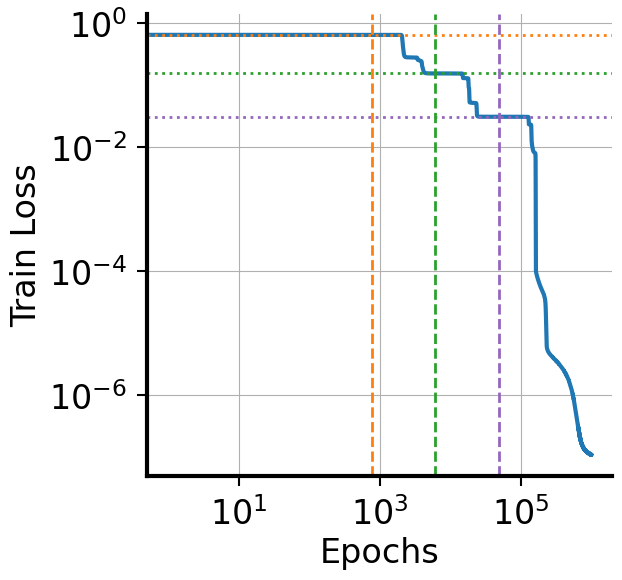

In [189]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Setup plot axis
ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)
ax.set_xscale('log')
ax.set_yscale('log')

# Plot empirical loss
ax.plot(loss_history, label='Loss', lw=3, color='tab:blue')

# Compute power spectrum
p = len(template)
freq, power = get_power(template)

# Remove near-zero values
threshold = 1e-20
valid = power > threshold
freq = freq[valid]
power = power[valid]

# Sort descending
sorted_idx = np.argsort(-power)
power = power[sorted_idx]
freq = freq[sorted_idx]

# Colors by frequency
highlight_colors = {1: 'tab:orange', 3: 'tab:green', 5: 'tab:purple'}
default_color = 'gray'

# Horizontal lines for alpha_k
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p  # from PyTorch MSE reduction
for k, alpha in enumerate(alpha_values):
    f = freq[k]
    color = highlight_colors.get(f, default_color)
    ax.axhline(y=coef * alpha, color=color, linestyle='dotted', linewidth=2)

# Vertical lines for tau_k
theta0 = np.sqrt(2) * model.init_scale
uMax = [np.sqrt(2 * p / 27) * (p * power[k]/2)**(3/2) / p**2 for k in range(len(power))]
tau_values = [(1 / theta0 - 1) / (3 * uMax[k]) for k in range(len(uMax))]
step_size = 2 * coef * lr / (1 - mom)
for k, tau in enumerate(tau_values):
    f = freq[k]
    color = highlight_colors.get(f, default_color)
    ax.axvline(x=tau / step_size, color=color, linestyle='dashed', linewidth=2)

style_axes(ax)
plt.savefig("loss.pdf", bbox_inches='tight')

## Plot Weights

/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/1173514334.py:109: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/1173514334.py:109: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/Users/danielkunin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


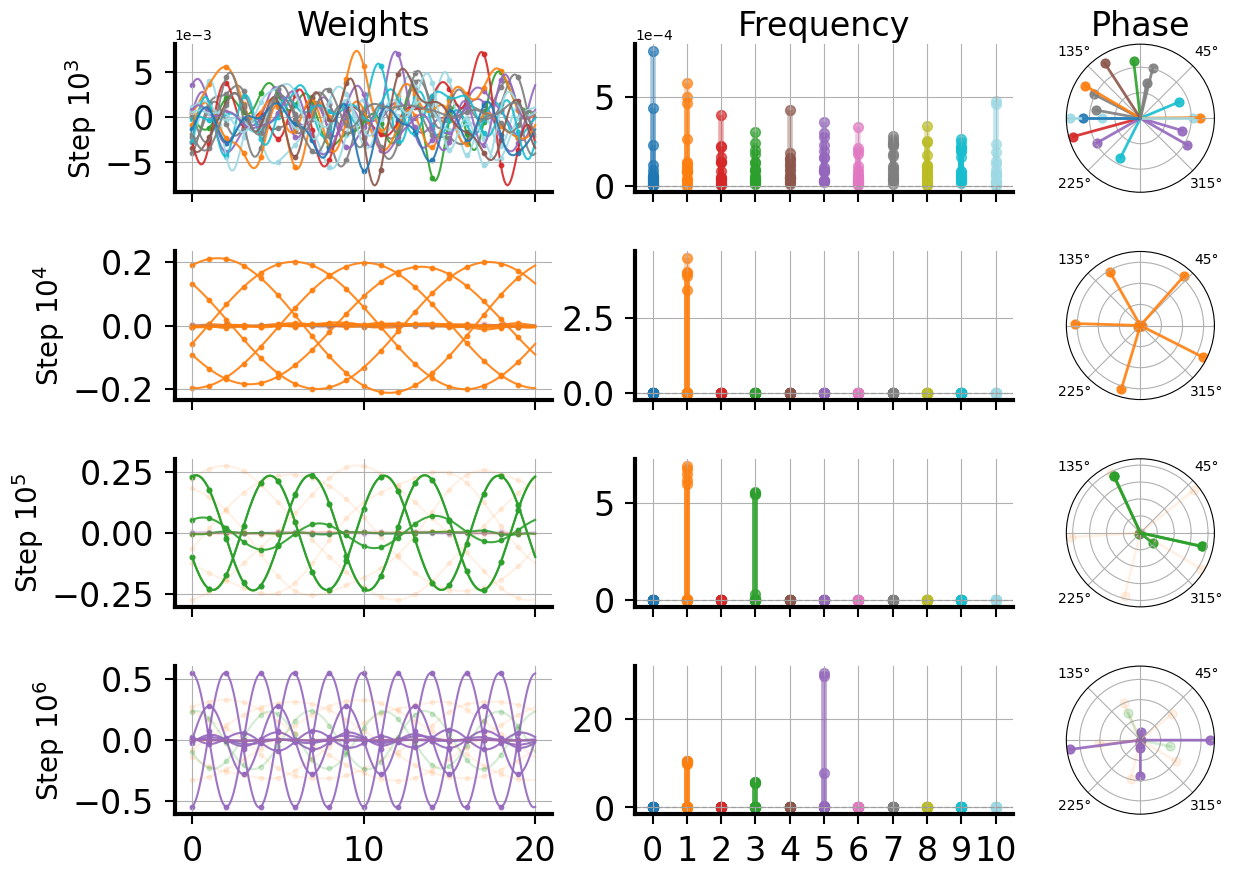

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Steps and corresponding highlighted frequencies

steps = [1000, 10000, 100000, epochs-1]
highlight_freqs_list = [[], [1], [3], [5]]

num_rows, num_cols = len(steps), 3

# Use gridspec to control layout
fig = plt.figure(figsize=(20, 10), constrained_layout=True)
gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1.2, 1.2, 2.0], wspace=0.18, hspace=0.4)
axes = np.empty((num_rows, num_cols), dtype=object)

# Create axes
for row in range(num_rows):
    for col in range(num_cols):
        if col == 2:
            ax = fig.add_subplot(gs[row, col], projection='polar')
        else:
            ax = fig.add_subplot(gs[row, col])  # ⬅ no sharex anymore
        axes[row, col] = ax

num_freqs = None
for row, index in enumerate(steps):
    highlight_freqs = highlight_freqs_list[row]
    params = param_history[index]
    W = params['W'].numpy()
    h, p = W.shape

    if num_freqs is None:
        num_freqs = p // 2 + 1
        cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
        colors = [cmap(i) for i in range(num_freqs)]
        manual_colors = {
            0: 'tab:blue',
            1: 'tab:orange',
            2: 'tab:red',
            3: 'tab:green',
            4: 'tab:brown',
            5: 'tab:purple',
        }
        freq_colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]


    # === Column 1: Weights ===
    ax = axes[row, 0]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        x = np.linspace(0, p - 1, 500)
        interpolate(ax, w, color=color, continuous=True, alpha=alpha)
        ax.scatter(np.arange(p), w, color=color, s=10, alpha=alpha)
    if row == 0: ax.set_title("Weights", fontsize=24)
    ax.set_ylabel(fr"Step $10^{{{int(np.log10(index))}}}$", fontsize=20)
    style_axes(ax)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 2: Frequency Spectrum ===
    ax = axes[row, 1]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        for k in range(len(power)):
            color = freq_colors[k]
            ax.vlines(k, 0, power[k], linewidth=4, color=color, alpha=0.4)
            ax.scatter(k, power[k], color=color, s=50, alpha=0.7)
    ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.4)
    ax.set_xlim(-0.5, len(power) - 0.5)
    ax.set_xticks(np.arange(len(power)))
    if row == 0: ax.set_title("Frequency", fontsize=24)
    style_axes(ax)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 3: Phase Polar Plot ===
    ax = axes[row, 2]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        phase = np.angle(ft[dom_idx])
        norm = np.linalg.norm(w)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        ax.plot([phase, phase], [0, norm], color=color, linewidth=2, alpha=alpha)
        ax.scatter(phase, norm, color=color, s=40, alpha=alpha)
        angles = np.arange(0, 360, 45)
        ax.set_thetagrids(angles, [f"{a}°" if a in [45,135,225,315] else "" for a in angles])
        ax.set_yticklabels([])
    if row == 0: ax.set_title("Phase", fontsize=24)

# Shift polar plots left to reduce whitespace
for row in range(num_rows):
    ax = axes[row, 2]
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.135, pos.y0, pos.width, pos.height])

plt.savefig("W-weights.pdf", bbox_inches='tight')

## Plot outputs

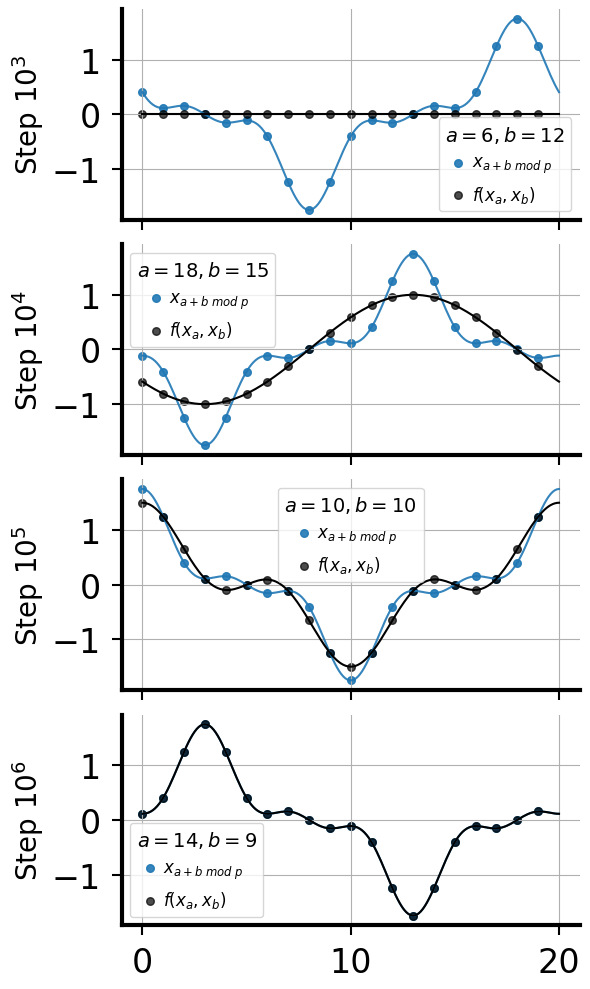

In [172]:
import matplotlib.pyplot as plt

# Choose time steps to visualize
steps_to_show = [1000, 10000, 100000, epochs-1]
num_samples = 1  # how many examples to plot per row
p = Y_tensor.shape[1]
x = np.arange(p)

fig, axes = plt.subplots(len(steps_to_show), 1, figsize=(6, 10), sharex=True)

for row, step in enumerate(steps_to_show):
    # Load weights at this step
    model.load_state_dict(param_history[step])
    model.eval()

    indices = np.random.choice(len(Y_tensor), size=num_samples, replace=False)
    with torch.no_grad():
        preds = model(X_tensor[indices]).detach().cpu().numpy()
        truths = Y_tensor[indices].detach().cpu().numpy()

    ax = axes[row]
    for i, idx in enumerate(indices):
        a = idx // p
        b = idx % p
        label_true = r"$x_{a + b \; mod \; p}$"
        label_pred = r"$f(x_a, x_b)$"

        # Plot ground truth
        interpolate(ax, truths[i], color=f"C{i}", alpha=0.9, continuous=True)
        ax.scatter(x, truths[i], color=f"C{i}", s=30, alpha=0.9, label=label_true)

        # Plot prediction
        interpolate(ax, preds[i], color='k', alpha=1.0, continuous=True)
        ax.scatter(x, preds[i], color='k', s=30, alpha=0.7, label=label_pred)

    style_axes(ax)
    ax.set_ylabel(fr"Step $10^{{{int(np.log10(step))}}}$", fontsize=20)

    # Only bottom row gets x-ticks
    if row < len(steps_to_show) - 1:
        ax.tick_params(labelbottom=False)

    ax.legend(loc='best', fontsize=12, title=fr"$a = {a}, b = {b}$", handlelength=0, title_fontsize=14)#, frameon=False)

# axes[-1].set_xlabel("Output Index", fontsize=20)
plt.tight_layout()
plt.savefig("predictions.pdf", bbox_inches='tight')

## Power Spectrum of output

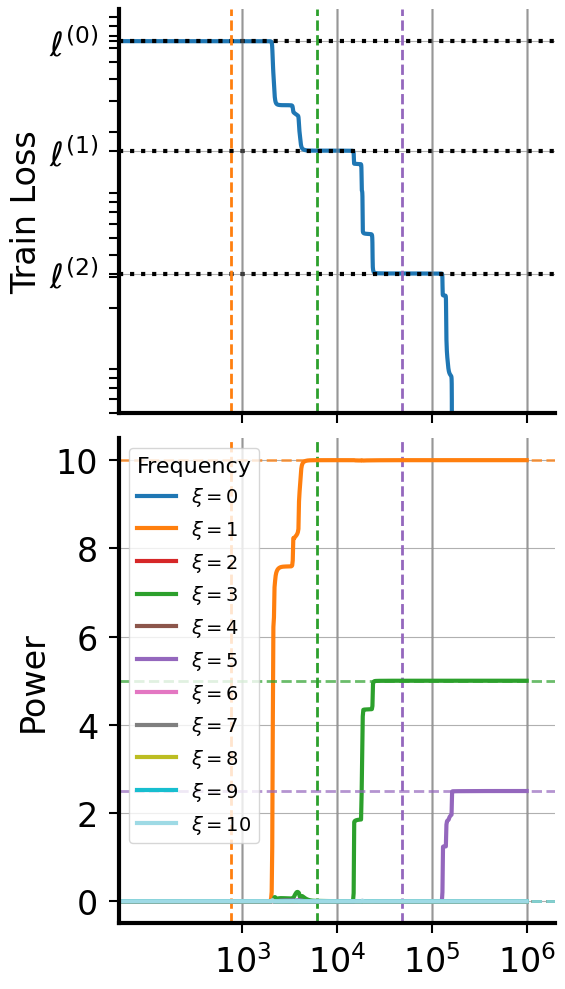

In [193]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

# === SETTINGS ===
p = Y_tensor.shape[1]
num_freqs = p // 2 + 1

# === Compute power spectrum of template ===
freq, power = get_power(template)
valid = power > 1e-20
freq, power = freq[valid], power[valid]
sorted_idx = np.argsort(-power)
freq, power = freq[sorted_idx], power[sorted_idx]

# === Theory lines ===
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p
theta0 = np.sqrt(2) * model.init_scale
uMax = [np.sqrt(2 * p / 27) * (p * power[k] / 2)**(3/2) / p**2 for k in range(len(power))]
tau_values = [(1 / theta0 - 1) / (3 * uMax[k]) for k in range(len(uMax))]
step_size = 2 * coef * lr / (1 - mom)

# === Compute output power over time ===
num_points = 1000
steps = np.unique(np.logspace(0, np.log10(len(param_history) - 1), num_points, dtype=int))
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
colors = [cmap(i) for i in range(num_freqs)]
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

powers_over_time = []

for step in steps:
    model.load_state_dict(param_history[step])
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        ft = np.fft.rfft(outputs.detach().cpu().numpy(), axis=1)
        avg_power = np.mean(np.abs(ft), axis=0)
        powers_over_time.append(avg_power)

powers_over_time = np.array(powers_over_time)  # shape: (steps, freqs)

# === Template power for horizontal lines ===
template_ft = np.fft.rfft(template)
template_power = np.abs(template_ft)[:num_freqs]

# === PLOTTING ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10), sharex=True, height_ratios=[1, 1.2])

# --- Top: Loss ---
ax1.plot(loss_history, lw=3, color='tab:blue', label='Train Loss')
ax1.set_yscale('log')
ax1.set_ylabel("Train Loss", fontsize=24)
ax1.tick_params(labelbottom=False)
ax1.set_xticklabels([])

for k, alpha in enumerate(alpha_values):
    color = colors[freq[k]]
    ax1.axhline(y=coef * alpha, color='black', linestyle='dotted', linewidth=3)
for k, tau in enumerate(tau_values):
    color = colors[freq[k]]
    ax1.axvline(x=tau / step_size, color=color, linestyle='dashed', linewidth=2)
    ax2.axvline(x=tau / step_size, color=color, linestyle='dashed', linewidth=2)

time_steps = [1000, 10000, 100000, epochs-1]
for k, step in enumerate(time_steps):
    ax1.axvline(x=step, color='grey', alpha=0.5, linestyle='solid', linewidth=2)
    ax2.axvline(x=step, color='grey', alpha=0.5, linestyle='solid', linewidth=2)


# --- Bottom: Fourier Power ---
for k in range(num_freqs):
    color = colors[k]
    ax2.plot(steps, powers_over_time[:, k], color=color, lw=3, label=fr"$\xi = {k}$")
    ax2.axhline(template_power[k], color=color, linestyle='dashed', linewidth=2, alpha=0.7)

ax2.set_ylabel("Power", fontsize=24)
# ax2.set_xlabel("Epochs", fontsize=24)
ax2.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper left')

# --- Formatting ---
ax1.set_xscale('log')
ax2.set_xscale('log')
style_axes(ax1)
style_axes(ax2)
ax1.grid(True)
ax2.grid(True)

ax1.set_ylim(5e-3, 1e0)
ax1.tick_params(labelbottom=False)
ax2.set_xlim(5e1, 2e6)
ax2.set_xticks(time_steps)
ax1.set_yticks([coef * a for a in alpha_values])
ax1.set_yticklabels([r'$\ell^{(0)}$', r'$\ell^{(1)}$', r'$\ell^{(2)}$'])

plt.tight_layout()
plt.savefig("combined_loss_power.pdf", bbox_inches="tight")
plt.show()